In [1]:
from torchvision import transforms
from PIL import Image
import cv2

In [2]:
def crop_image(image):
    # Ritaglia la parte superiore (macchina) e inferiore (pannello)

    top_crop = transforms.functional.crop(image, 0, 0, 84, 96)  # Prima metà
    bottom_crop = transforms.functional.crop(image, 84, 0, 12, 96)  # Seconda metà
    
    return top_crop, bottom_crop

In [3]:
# Testa la funzione
image_path = "train/0/0000.png"
image = Image.open(image_path).convert("RGB")
top, bottom = crop_image(image)

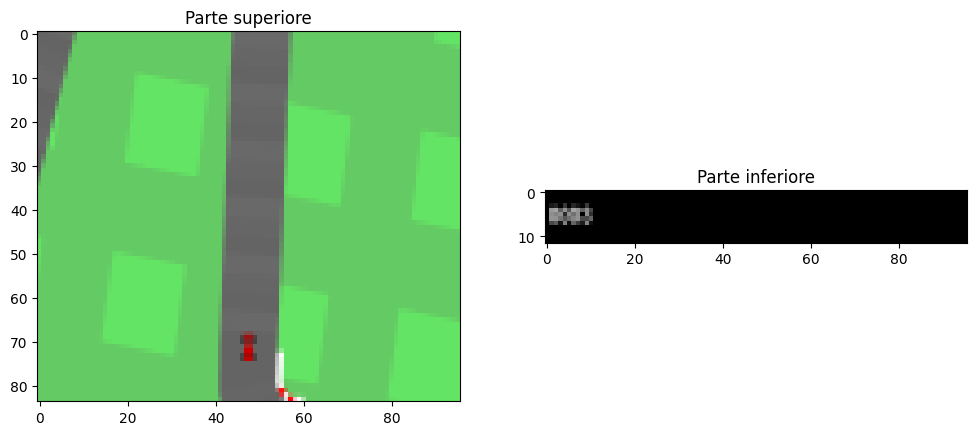

In [4]:
# Visualizza i ritagli
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Parte superiore")
plt.imshow(top)
plt.subplot(1, 2, 2)
plt.title("Parte inferiore")
plt.imshow(bottom)
plt.show()

# CNN Model

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Imposta il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
class DualInputModel(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(DualInputModel, self).__init__()
        
        # Rete per la parte superiore (orientamento auto)
        self.top_net = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 24x24
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Output: 12x12
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Dropout(dropout_rate),
            nn.AdaptiveAvgPool2d((6, 6))  # Adatta a output compatto
        )
        
        # Rete per la parte inferiore (pannello)
        self.bottom_net = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 24x24
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 12x12
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.AdaptiveAvgPool2d((6, 6))
        )
        
        # Combinazione dei due output
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 6 * 6 * 2, 128),  # 2 parti
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 azioni
        )
    
    def forward(self, top_input, bottom_input):
        top_out = self.top_net(top_input)
        bottom_out = self.bottom_net(bottom_input)
        combined = torch.cat((top_out.view(top_out.size(0), -1),
                              bottom_out.view(bottom_out.size(0), -1)), dim=1)
        return self.fc(combined)

# Inizializza il modello
model = DualInputModel().to(device)
print(model)

DualInputModel(
  (top_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (bottom_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 

Data Preparation

In [7]:
# Trasformazioni per pre-elaborare l'immagine
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize delle immagini
    transforms.ToTensor()
])

# Classe personalizzata per dataset dual-input
class DualInputDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Divide l'immagine in due parti
        top_img, bottom_img = crop_image(img)
        
        return top_img, bottom_img, label
    
    def __len__(self):
        return len(self.dataset)
    

In [8]:
# Loss e Ottimizzatore
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()

# Funzione per il training
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for top_imgs, bottom_imgs, labels in loader:
        top_imgs, bottom_imgs, labels = top_imgs.to(device), bottom_imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(top_imgs, bottom_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

# Funzione per l'evaluazione
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for top_imgs, bottom_imgs, labels in loader:
            top_imgs, bottom_imgs, labels = top_imgs.to(device), bottom_imgs.to(device), labels.to(device)
            outputs = model(top_imgs, bottom_imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy

## Train Normal Data 

In [9]:
# Percorso del dataset
data_dir = "./train_balanced"  # Sostituisci con il tuo percorso
train_dataset = DualInputDataset(root_dir=data_dir, transform=transform)

# Split in train/test
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [10]:
'''
num_epochs = 6

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
    test_acc = evaluate_model(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%\n")

final_test_dataset = DualInputDataset(root_dir='./test', transform=transform)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=True)

evaluate_model(model, final_test_loader)
'''

'\nnum_epochs = 6\n\nfor epoch in range(num_epochs):\n    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)\n    test_acc = evaluate_model(model, test_loader)\n    \n    print(f"Epoch {epoch+1}/{num_epochs}")\n    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")\n    print(f"Test Accuracy: {test_acc:.2f}%\n")\n\nfinal_test_dataset = DualInputDataset(root_dir=\'./test\', transform=transform)\nfinal_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=True)\n\nevaluate_model(model, final_test_loader)\n'

### Hyperparameter Search

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [12]:
test_set = DualInputDataset(root_dir='./test', transform=transform)
test_set_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [13]:
# Parametri di ricerca
epoch_list = [10, 20]
learning_rate_list = [0.01]
dropout_list = [0, 0.25, 0.5]
weight_decay_list = [0.0001]

In [14]:
results = []
# Inizia la grid search
for dropout_rate in dropout_list:
    for lr in learning_rate_list:
        for weight_decay in weight_decay_list:
            for epochs in epoch_list:
                print(f"Training with dropout {dropout_rate}, lr {lr}, wd {weight_decay}, epochs {epochs}...")
                
                # Definisci il modello
                model = DualInputModel(dropout_rate=dropout_rate).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = nn.CrossEntropyLoss()

                # Training loop
                model.train()
                all_labels = []  # Per tenere traccia di tutte le etichette
                all_predictions = []  # Per tenere traccia di tutte le predizioni

                for epoch in range(epochs):
                    epoch_loss = 0
                    correct = 0
                    total = 0
                    for top_imgs, bottom_imgs, labels in train_loader:

                        top_imgs, bottom_imgs, labels = top_imgs.to(device), bottom_imgs.to(device), labels.to(device)

                        optimizer.zero_grad()
                        outputs = model(top_imgs, bottom_imgs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()
                        
                        # Aggiungi le etichette e le predizioni alla lista
                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())
                    
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100. * correct / total:.2f}%")

                # Ora valutiamo il modello sul test set
                model.eval()
                all_labels = []  # Per tenere traccia di tutte le etichette
                all_predictions = []  # Per tenere traccia di tutte le predizioni

                with torch.no_grad():  # Disabilita il calcolo del gradiente per la valutazione
                    for top_imgs, bottom_imgs, labels in test_loader:
                        top_imgs, bottom_imgs, labels = top_imgs.to(device), bottom_imgs.to(device), labels.to(device)

                        outputs = model(top_imgs, bottom_imgs)
                        _, predicted = outputs.max(1)

                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())
                
                # Calcola precision, recall, f1 score sul test set
                precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
                recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
                f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

                # Registra risultati finali
                results.append({
                    "dropout_rate": dropout_rate,
                    "learning_rate": lr,
                    "weight_decay": weight_decay,
                    "epochs": epochs,
                    "final_accuracy": 100. * correct / total,
                    "final_loss": epoch_loss,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1
                })

# Mostra i risultati
print("Results:")
for result in results:
    print(result)

Training with dropout 0, lr 0.01, wd 0.0001, epochs 10...
Epoch 1/10, Loss: 75.9883, Accuracy: 19.51%
Epoch 2/10, Loss: 75.6797, Accuracy: 20.12%
Epoch 3/10, Loss: 75.7159, Accuracy: 18.70%
Epoch 4/10, Loss: 75.7210, Accuracy: 17.95%
Epoch 5/10, Loss: 75.6769, Accuracy: 19.38%
Epoch 6/10, Loss: 75.6928, Accuracy: 18.90%
Epoch 7/10, Loss: 75.6999, Accuracy: 19.24%
Epoch 8/10, Loss: 75.6972, Accuracy: 18.50%
Epoch 9/10, Loss: 75.6810, Accuracy: 19.85%
Epoch 10/10, Loss: 75.6890, Accuracy: 18.90%
Training with dropout 0, lr 0.01, wd 0.0001, epochs 20...
Epoch 1/20, Loss: 74.4515, Accuracy: 26.76%
Epoch 2/20, Loss: 70.1141, Accuracy: 34.89%
Epoch 3/20, Loss: 68.2230, Accuracy: 37.60%
Epoch 4/20, Loss: 68.0364, Accuracy: 38.62%
Epoch 5/20, Loss: 67.7541, Accuracy: 37.33%
Epoch 6/20, Loss: 67.4802, Accuracy: 38.48%
Epoch 7/20, Loss: 67.3327, Accuracy: 38.75%
Epoch 8/20, Loss: 67.4929, Accuracy: 38.75%
Epoch 9/20, Loss: 67.2712, Accuracy: 39.30%
Epoch 10/20, Loss: 66.7197, Accuracy: 39.09%
Ep

Find best parameters (tradeoff between Accuracy and F1-score)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Converte la lista dei risultati in un DataFrame pandas
results_df = pd.DataFrame(results)

In [16]:
# Calcolo del punteggio di trade-off
results_df["tradeoff_score"] = (results_df["final_accuracy"] + results_df["f1_score"]) / 2

# Trovare la combinazione con il punteggio di trade-off massimo
best_combination = results_df.sort_values(by="tradeoff_score", ascending=False).iloc[0]

print("Combinazione migliore per Accuracy e F1 Score:")
print(best_combination)

# Visualizzare le prime 5 combinazioni
top_5_combinations = results_df.sort_values(by="tradeoff_score", ascending=False).head(5)
print("\nTop 5 combinazioni per Accuracy e F1 Score:")
print(top_5_combinations)

Combinazione migliore per Accuracy e F1 Score:
dropout_rate       0.250000
learning_rate      0.010000
weight_decay       0.000100
epochs            20.000000
final_accuracy    39.972900
final_loss        66.410552
precision          0.494542
recall             0.447154
f1_score           0.410105
tradeoff_score    20.191502
Name: 3, dtype: float64

Top 5 combinazioni per Accuracy e F1 Score:
   dropout_rate  learning_rate  weight_decay  epochs  final_accuracy  \
3          0.25           0.01        0.0001      20       39.972900   
1          0.00           0.01        0.0001      20       39.227642   
2          0.25           0.01        0.0001      10       39.227642   
5          0.50           0.01        0.0001      20       39.227642   
4          0.50           0.01        0.0001      10       20.392954   

   final_loss  precision    recall  f1_score  tradeoff_score  
3   66.410552   0.494542  0.447154  0.410105       20.191502  
1   66.588457   0.435321  0.414634  0.373314 

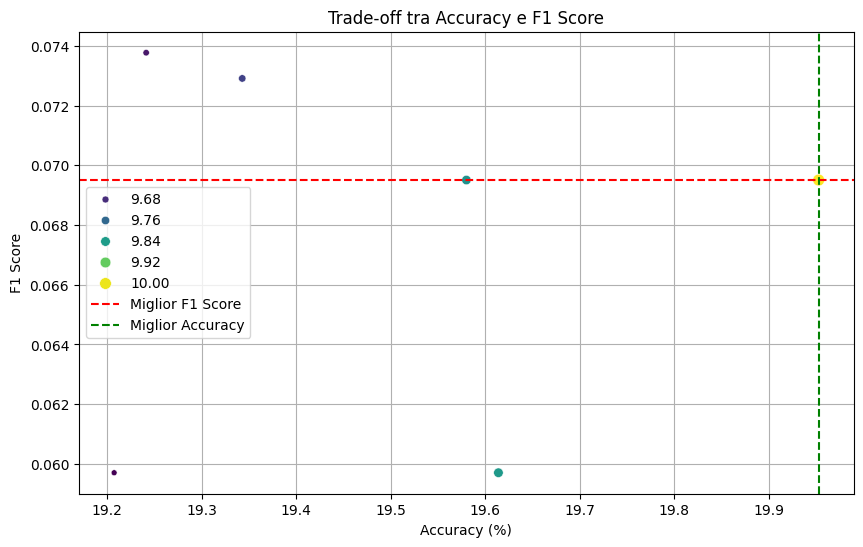

In [35]:
# Visualizzare graficamente il trade-off tra Accuracy e F1 Score
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df, 
    x="final_accuracy", 
    y="f1_score", 
    hue="tradeoff_score", 
    size="tradeoff_score", 
    palette="viridis", 
    legend="brief"
)
plt.title("Trade-off tra Accuracy e F1 Score")
plt.xlabel("Accuracy (%)")
plt.ylabel("F1 Score")
plt.axhline(y=best_combination["f1_score"], color="r", linestyle="--", label="Miglior F1 Score")
plt.axvline(x=best_combination["final_accuracy"], color="g", linestyle="--", label="Miglior Accuracy")
plt.legend()
plt.grid()
plt.show()